Average Accuracy: 100.00%


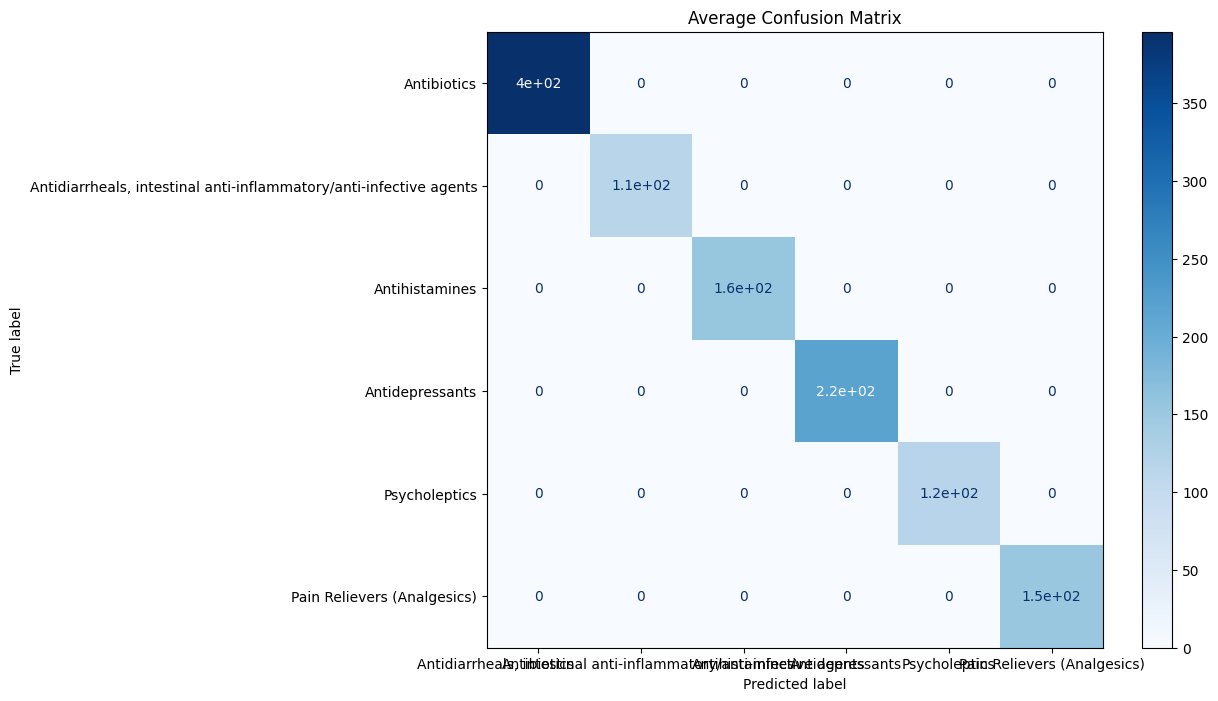

Sample prediction:
Category: Pain Relievers (Analgesics)
Confidence: 99.51%


In [23]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
import json

# Load the datasets
dataset = pd.read_csv(r'C:\src\pedimed\lib\data\Modified_dataset.csv')
category_label = pd.read_csv(r'C:\src\pedimed\lib\data\category_label.csv')
unit_label = pd.read_csv(r'C:\src\pedimed\lib\data\unit_label.csv')

# Create a mapping for Dosage_Unit to Dosage_Unit_Label
unit_mapping = dict(zip(unit_label['Dosage_Unit'], unit_label['Dosage_Unit_Label']))

# Map Dosage_Unit to Dosage_Unit_Label in the dataset
dataset['Dosage_Unit_Label'] = dataset['Dosage_Unit'].map(unit_mapping)

# Prepare the data
X = dataset.drop(columns=['Unnamed: 0', 'Brand_Names', 'Category', 'Category_Label', 'Dosage_Unit'])
y = dataset['Category_Label']

# Save column names before transforming
column_names = X.columns.tolist()

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the SVM model
clf = svm.SVC(kernel='linear', probability=True)

# Set up k-fold cross-validation
k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []
confusion_matrices = []

# Perform cross-validation
for train_index, test_index in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(conf_matrix)

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

# Calculate and display the average confusion matrix
average_conf_matrix = np.mean(confusion_matrices, axis=0)

# Plot average confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=average_conf_matrix, display_labels=category_label['Category'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Average Confusion Matrix')
plt.show()

# Save the trained SVM model
clf.fit(X_scaled, y)  # Train on the entire dataset
joblib.dump(clf, 'svm_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the selected features indices if needed (assuming all features are used)
selected_feature_indices = np.arange(X_scaled.shape[1])
np.save('selected_features.npy', selected_feature_indices)

# Save the feature names
feature_names = list(column_names)
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)

# Predict and evaluate on a sample input
sample_input = {
    'Dosage': 120.0,
    'DosageFreq': 3,
    'Dosage_Unit': 'MG',  # Example dosage unit
    'Drug_Name_Amoxicillin': 0,
    'Drug_Name_Atomoxetine': 0,
    'Drug_Name_Azithromycin': 0,
    'Drug_Name_Budesonide': 0,
    'Drug_Name_Cefixime': 0,
    'Drug_Name_Cephalexin': 0,
    'Drug_Name_Clarithromycin': 0,
    'Drug_Name_Clotrimazole': 0,
    'Drug_Name_Codeine': 0,
    'Drug_Name_Dexamethasone': 0,
    'Drug_Name_Diclofenac': 0,
    'Drug_Name_Doxycycline': 0,
    'Drug_Name_Erythromycin': 0,
    'Drug_Name_Fluconazole': 0,
    'Drug_Name_Ibuprofen': 0,
    'Drug_Name_Loratadine': 0,
    'Drug_Name_Metronidazole': 0,
    'Drug_Name_Mometasone': 0,
    'Drug_Name_Paracetamol': 1,
    'Drug_Name_Prednisolone': 0,
    'Drug_Name_Ranitidine': 0,
    'Drug_Name_Salmeterol': 0,
    'Drug_Name_Sulfamethoxazole/Trimethoprim': 0,
    'Drug_Name_Tobramycin': 0,
    'Drug_Name_Vancomycin': 0,
    'Formulation_Capsule': 0,
    'Formulation_Eyedrop': 0,
    'Formulation_Liquid': 1,
    'Formulation_Others': 0,
    'Formulation_Tablet': 0
}

# Map Dosage_Unit to Dosage_Unit_Label in the sample input
sample_input['Dosage_Unit_Label'] = unit_mapping[sample_input['Dosage_Unit']]
del sample_input['Dosage_Unit']

# Ensure all necessary columns are included in the sample input
sample_df = pd.DataFrame([sample_input])
sample_df = sample_df.reindex(columns=column_names, fill_value=0)

# Scale the sample input using the same scaler
sample_df_scaled = scaler.transform(sample_df)

# Predict category and confidence for the sample input
sample_pred = clf.predict(sample_df_scaled)
sample_pred_prob = clf.predict_proba(sample_df_scaled)

# Get the category name
category_name = category_label[category_label['Category_Label'] == sample_pred[0]]['Category'].values[0]
confidence = sample_pred_prob[0][sample_pred[0]]

print(f"Sample prediction:")
print(f"Category: {category_name}")
print(f"Confidence: {confidence * 100:.2f}%")
